# Um dia no papel de um analista de dados financeiros

## Pedido do Cliente

Um cliente questionou-nos se tem sido mais vantajoso investir no MSCI World ou no S&P 500, durante a última década (vamos imaginar inicialmente um período de 2011-12-30 a 2021-12-30).

Pediu um gráfico onde pudesse ver isso mas também a taxa de crescimento de cada investimento.

Pediu também que analisássemos o Lyxor Euro Government Bond 15+Y (DR) que é de obrigações governamentais europeis de muito longo prazo.

No fim pediu-nos uma opinião sobre a combinação de dois fundos que neste período analisado trouxeram maior diversificação e quais os dois ETFs que deveria usar na criação da sua carteira diversificada.

## O que vamos precisar de fazer

1) Faça um gráfico de linhas comparativo entre:

- CSPX.AS (S&P 500 UCITS ETF)
- IWDA.AS (MSCI World UCITS ETF)
- LYXF.F (Lyxor Euro Government Bond 15+Y)

desde 2011-12-30 até 2021-12-31

2) Faça um gráfico de dispersão para cada 3 dos pares. Qual é a conclusão a que chegamos?

3) Faça um map de calor das correlações. Confirmou as suas suspeitas?

4) Qual é o g (crescimento) de cada ETF nestes 10 anos? O que é que isto representa?

5) Com a fórmula compute_FV_lump_sum() confirme os dados do g.

6) Actualize a análise para o dia de hoje.

7) Vamos para além do que o cliente pediu e vamos fazer um gráfico de barras com os retornos anuais. É um informação útil e o cliente vai ficar satisfeito.

In [2]:
#Importacao das libraries

import numpy as np
import pandas as pd
import yfinance as yf
import math
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats as stats
import pingouin

In [3]:
#Definição das variáveis do problema

tickers = ['CSPX.AS', 'IWDA.AS', 'LYXF.F']
start = '2011-12-30'
end = '2021-12-31'

## O que é um ETF?

 - ETF é uma sigla que vem de Exchange Traded Fund, em português pode-se dizer que é um fundo “trocável” em bolsa, ou seja, pode-se comprar e vender em bolsa, ao contrário dos fundos de investimento tradicionais.

 - Os ETF podem ser constituídos por todos os tipos de investimentos, tais como: ações, obrigações, comodities e pares cambiais. Estes podem também dividir-se por setores.

 - A maioria dos ETF seguem uma filosofia de gestão passiva, seguindo um ìndice como o S&P500 por exemplo. Ao ser de gestão passiva permite ter uma Taxa de gestão muito baixa.
 
 - Ler mais: https://www.investopedia.com/terms/e/etf.asp

## CSPX

Este ETF segue o índice S&P500, o índice mais usado para fins de benchmarking. O Fundo busca acompanhar o desempenho de um índice composto por 500 empresas norte-americanas de grande capitalização de mercado.

TER : 0.07% anual

Distribuição : Acumulativo

Replicação : Física (Compra e vende as ações)

Tamanho do fundo : 67.7B USD

Data de lançamento do fundo : 18 maio 2010

Número de participações : 503

Top 10 Holdings, a 6 dezembro 2023:

![](https://s3.us-east-2.amazonaws.com/cbs.pg.repository/img/Chapter_1_exercice_1.PNG)

Alocação a Setores, a 6 de dezembro 2023:

![](https://s3.us-east-2.amazonaws.com/cbs.pg.repository/img/Chapter_1_exercice_1.PNG)


## IWDA

O Fundo busca acompanhar o desempenho de um índice composto por empresas de países desenvolvidos. 

Encargos Totais Correntes : 0.2% anual

Distribuição : Acumulativo

Replicação : Física (Compra e vende as ações)

Tamanho do fundo : 62.2B USD

Data de lançamento do fundo : 25 setembro 2009

Número de participações : 1485

Top 10 Holdings, a 6 dezembro 2023:

![image.png](attachment:image.png)

Alocação a Setores, a 6 de dezembro 2023:

![image-2.png](attachment:image-2.png)

## LYXF

Este Fundo replica o índice da Bloomberg de Obrigações do tesouro Europeias de 15+ anos  

Encargos Totais Correntes : 0.17% anual

Distribuição : Acumulativo

Replicação : Física (Compra e vende as obrigações)

Tamanho do fundo : 88M €

Data de lançamento do fundo : 20 junho 2007

Top 10 Exposição por país, a 6 de dezembro 2023:

![image.png](attachment:image.png)


## 1) Faça um gráfico de linhas comparativo entre:

In [4]:
#Definicao de variaveis

def merge_time_series(df_1, df_2, how='outer'):
    df = df_1.merge(df_2, how=how, left_index=True, right_index=True)
    return df

def normalize(df):
    df = df.dropna()
    return (df / df.iloc[0]) * 100

def download_yahoo_data(tickers, normalize_quotes=False,
                      start=start, end=end):
    quotes = pd.DataFrame()
    for ticker in tickers:
        df = yf.download(ticker, start=start, end=end, progress=False)
        df = df[['Adj Close']]
        df.columns=[ticker]
        quotes = merge_time_series(quotes, df)
    
    quotes = quotes.ffill()
     
    if normalize_quotes:
        quotes = normalize(quotes)

    return quotes

In [5]:
ETFs = download_yahoo_data(tickers, start=start, end=end)

# Resample para business month
# (seleccionando o último preço de cada dia útil do mês)
ETFs_mensal = ETFs.resample('BM').last()

ETFs_mensal

,CSPX.AS,IWDA.AS,LYXF.F
Date,,,
2011-12-30,84.595001,20.780001,125.348900
2012-01-31,87.040001,21.565001,127.177803
2012-02-29,89.144997,22.200001,131.210907
2012-03-30,92.165001,22.584999,130.917297
2012-04-30,92.144997,22.395000,130.770996
...,...,...,...
2021-08-31,390.382996,73.379997,274.119995
2021-09-30,382.233002,72.000000,266.369995
2021-10-29,405.216003,75.745003,268.350006


In [6]:
# Fazer com que as séries temporais comecem do mesmo ponto
ETFs_mensal = normalize(ETFs_mensal)

# Fazer gráfico vazio
fig = go.Figure()

# Mover legenda para baixo
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=-0.5,
    xanchor="center",
    x=0.5
))

# Adicionar as linhas (uma a uma)
fig = fig.add_trace(go.Scatter(x=ETFs_mensal.index, y=ETFs_mensal['CSPX.AS'], name='S&P500'))
fig = fig.add_trace(go.Scatter(x=ETFs_mensal.index, y=ETFs_mensal['IWDA.AS'], name='MSCI WORLD'))
fig = fig.add_trace(go.Scatter(x=ETFs_mensal.index, y=ETFs_mensal['LYXF.F'], name='15+Yr EURO GOVERNMENT BOND'))

# Acrescentar símbolos de dólar e títulos nos eixos
fig = fig.update_yaxes(title='Preço ($)', ticksuffix='$')

# Acrescentar tema
fig = fig.update_layout(template='seaborn',
                        title='Analise Cliente Trabalho',
                        height=420,
                        width=790)

fig.show()

## 2) Faça um gráfico de dispersão para cada 3 dos pares. Qual é a conclusão a que chegamos?

In [7]:
tickers

['CSPX.AS', 'IWDA.AS', 'LYXF.F']

In [8]:
#Usar o primeiro valor da lista

tickers[0]

'CSPX.AS'

In [9]:
#Usar o ultimo valor da lista

tickers[-1]

'LYXF.F'

In [10]:
ETFs_ret = ETFs_mensal.pct_change()

# Fazer scatter plot
fig = px.scatter(ETFs_ret, x=tickers[0], y=tickers[1])

# Acrescentar tema
fig = fig.update_layout(template='seaborn')

fig.show()

In [11]:
ETFs_ret = ETFs_mensal.pct_change()

# Fazer scatter plot
fig = px.scatter(ETFs_ret, x=tickers[0], y=tickers[2])

# Acrescentar tema
fig = fig.update_layout(template='seaborn')

fig.show()

In [12]:
ETFs_ret = ETFs_mensal.pct_change()

# Fazer scatter plot
fig = px.scatter(ETFs_ret, x=tickers[1], y=tickers[2])

# Acrescentar tema
fig = fig.update_layout(template='seaborn')

fig.show()

![](https://s3.us-east-2.amazonaws.com/cbs.pg.repository/img/capitulo_02/interpreting-a-scatter-plot.jpg)

<small>**Fonte:** https://www.latestquality.com/interpreting-a-scatter-plot/</small>

R: Através dos gráficos de dispersão podemos concluir que apenas o CSPX e IWDA estão correlacionados, estes apresentam uma correlação positiva.
Os Euro Bonds não têm correlação com os 2 ETFs analisados.


## 3) Faça um mapa de calor das correlações. Confirmou as suas suspeitas?

In [13]:
# Calcular e usar retornos para comparações de correlação
ETFs_mensal_ret = ETFs_mensal.pct_change()

# É sempre aconselhável tirar quaisquer na's
# Remove all rows wit NULL values from the DataFrame.
ETFs_mensal_ret = ETFs_mensal_ret.dropna()

ETFs_mensal_ret_corr = ETFs_mensal_ret.corr()

ETFs_mensal_ret_corr

,CSPX.AS,IWDA.AS,LYXF.F
CSPX.AS,1.000000,0.966787,0.083306
IWDA.AS,0.966787,1.000000,0.087814
LYXF.F,0.083306,0.087814,1.000000


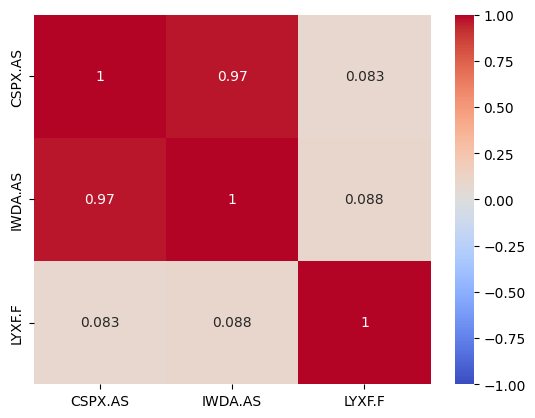

In [14]:
sns.heatmap(ETFs_mensal_ret_corr,
           annot=True,
           vmin=-1, vmax=1,
           cmap='coolwarm')

plt.show()

R: Com o mapa de calor, venho uma vez mais, confirmar as minhas suspeitas da alínea anterior. O IWDA e CSPX têm uma correlação positiva. Os Euro Bonds não exibem qualquer correlação com os ETF analisados.

## 4) Qual é o g (crescimento) de cada ETF nestes 10 anos? O que é que isto representa?

In [15]:
tickers

['CSPX.AS', 'IWDA.AS', 'LYXF.F']

In [16]:
ETFs_mensal

,CSPX.AS,IWDA.AS,LYXF.F
Date,,,
2011-12-30,100.000000,100.000000,100.000000
2012-01-31,102.890241,103.777670,101.459050
2012-02-29,105.378563,106.833494,104.676553
2012-03-30,108.948519,108.686229,104.442319
2012-04-30,108.924872,107.771895,104.325603
...,...,...,...
2021-08-31,461.472888,353.127983,218.685601
2021-09-30,451.838757,346.486995,212.502858
2021-10-29,479.007031,364.509145,214.082458


In [17]:
#Calcular CAGR r 
def compute_g(FV, PV, N):
    '''
    g = compounded growth
    FV = Future Value
    PV = Present Value
    n = years
    '''
    g = ((FV/PV)**(1/N))-1
    return g

In [18]:
#Growth CSPX.AS

gCSPX = compute_g(ETFs_mensal[tickers[0]].iloc[-1],100,10)

print("O retorno anualizado do CSPX é de ", gCSPX)

O retorno anualizado do CSPX é de  0.17736225197087618


In [19]:
#Growth IWDA.AS

gIWDA = compute_g(ETFs_mensal[tickers[1]].iloc[-1],100,10)

print("O retorno anualizado do IWDA é de ", gIWDA)

O retorno anualizado do IWDA é de  0.14335718784119966


In [20]:
#Growth LYXF.F

gLYXF = compute_g(ETFs_mensal[tickers[2]].iloc[-1],100,10)

print("O retorno anualizado do LYXF é de ", gLYXF)

O retorno anualizado do LYXF é de  0.07857122937945471


## 5) Com a fórmula compute_FV_lump_sum() confirme os dados do g.

In [21]:
#Valor futuro de um cash flow único com capitalização superior a 1
def compute_FV_lump_sum(PV, r, N, m):
    '''
    PV = Present value / Valor actual
    r = Stated rate / Taxa de juro cotada
    N = número de anos
    m = número de capitalizações anuais
    '''
    FV = PV * (1+r/m)**(N*m)
    return FV

In [22]:
#FV CSPX

FVCSPX = compute_FV_lump_sum(100,gCSPX,10,1)

print(FVCSPX)

511.80093571124735


In [23]:
#FV IWDA

FVIWDA = compute_FV_lump_sum(100,gIWDA,10,1)

print(FVIWDA)

381.7853535272413


In [24]:
#FV LYXF

FVLYXF = compute_FV_lump_sum(100,gLYXF,10,1)

print(FVLYXF)

213.05332387973962


R: Os Future value vêm confimar a média geométrica calculada no passo anterior.

## 6) Actualize a análise para o dia de hoje.

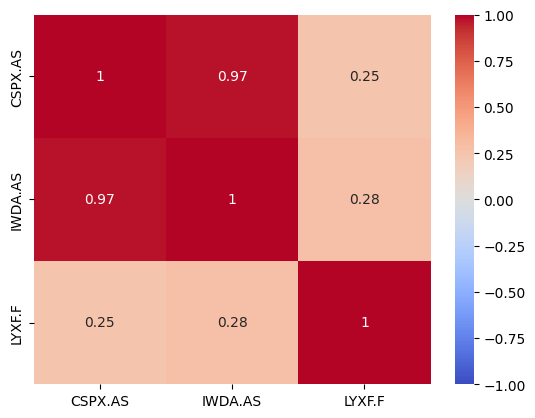

,CSPX.AS,IWDA.AS,LYXF.F
Date,,,
2011-12-30,100.000000,100.000000,100.000000
2012-01-31,102.890241,103.777670,101.459050
2012-02-29,105.378563,106.833494,104.676553
2012-03-30,108.948519,108.686229,104.442319
2012-04-30,108.924872,107.771895,104.325603
...,...,...,...
2023-08-31,515.106084,377.935520,138.389728
2023-09-29,503.764995,371.944169,129.231294
2023-10-31,488.374028,359.359964,129.123587


In [25]:
#Definição das variáveis do problema

tickers = ['CSPX.AS', 'IWDA.AS', 'LYXF.F']
start = '2011-12-30'
end2 = '2030-12-31'

#Definicao de variaveis

def merge_time_series(df_1, df_2, how='outer'):
    df = df_1.merge(df_2, how=how, left_index=True, right_index=True)
    return df

def normalize(df):
    df = df.dropna()
    return (df / df.iloc[0]) * 100

def download_yahoo_data(tickers, normalize_quotes=False,
                      start=start, end=end2):
    quotes=pd.DataFrame()
    for ticker in tickers:
        df = yf.download(ticker, start=start, end=end2, progress=False)
        df = df[['Adj Close']]
        df.columns=[ticker]
        quotes = merge_time_series(quotes, df)
    
    quotes = quotes.ffill()
     
    if normalize_quotes:
        quotes = normalize(quotes)

    return quotes

ETFs2 = download_yahoo_data(tickers, start=start, end=end2)

# Resample para business month
# (seleccionando o último preço de cada dia útil do mês)
ETFs2_mensal = ETFs2.resample('BM').last()


# Fazer com que as séries temporais comecem do mesmo ponto
ETFs2_mensal = normalize(ETFs2_mensal)

# Fazer gráfico vazio
fig = go.Figure()

# Mover legenda para baixo
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=-0.5,
    xanchor="center",
    x=0.5
))

# Adicionar as linhas (uma a uma)
fig = fig.add_trace(go.Scatter(x=ETFs2_mensal.index, y=ETFs2_mensal[tickers[0]], name='S&P500'))
fig = fig.add_trace(go.Scatter(x=ETFs2_mensal.index, y=ETFs2_mensal[tickers[1]], name='MSCI WORLD'))
fig = fig.add_trace(go.Scatter(x=ETFs2_mensal.index, y=ETFs2_mensal[tickers[2]], name='15+Yr EURO GOVERNMENT BOND'))

# Acrescentar símbolos de dólar e títulos nos eixos
fig = fig.update_yaxes(title='Preço ($)', ticksuffix='$')

# Acrescentar tema
fig = fig.update_layout(template='seaborn',
                        title='Analise Cliente Trabalho Hoje',
                        height=420,
                        width=790)

fig.show()



#GRAFICOS DE DISPERSAO
ETFs2_ret = ETFs2_mensal.pct_change()
# Fazer scatter plot
fig = px.scatter(ETFs2_ret, x=tickers[0], y=tickers[1])
# Acrescentar tema
fig = fig.update_layout(template='seaborn')
fig.show()


#GRAFICOS DE DISPERSAO
ETFs2_ret = ETFs2_mensal.pct_change()
# Fazer scatter plot
fig = px.scatter(ETFs2_ret, x=tickers[0], y=tickers[2])
# Acrescentar tema
fig = fig.update_layout(template='seaborn')
fig.show()

#GRAFICO DE DISPERSAO
ETFs2_ret = ETFs2_mensal.pct_change()
# Fazer scatter plot
fig = px.scatter(ETFs_ret, x=tickers[1], y=tickers[2])
# Acrescentar tema
fig = fig.update_layout(template='seaborn')
fig.show()


#CORRELACOES
# Calcular e usar retornos para comparações de correlação
ETFs2_mensal_ret = ETFs2_mensal.pct_change()

# É sempre aconselhável tirar quaisquer na's
# Remove all rows wit NULL values from the DataFrame.
ETFs2_mensal_ret = ETFs2_mensal_ret.dropna()

ETFs2_mensal_ret_corr = ETFs2_mensal_ret.corr()

sns.heatmap(ETFs2_mensal_ret_corr,
           annot=True,
           vmin=-1, vmax=1,
           cmap='coolwarm')

plt.show()

ETFs2_mensal

In [26]:
print(ETFs2_mensal[tickers[0]].iloc[-1])
print(ETFs2_mensal[tickers[1]].iloc[-1])
print(ETFs2_mensal[tickers[2]].iloc[-1])


525.0759286856572
386.7901700872121
145.1508609605355


In [27]:
#Ir buscar o ultimo valor da serie temporal
#last_price_stock_1 = ETFs2_mensal["1"].iloc[-1]

last_day = ETFs2_mensal_ret.iloc[-1].name.strftime('%Y-%m-%d')

gCSPX2 = compute_g(ETFs2_mensal[tickers[0]].iloc[-1],100,12)
gIWDA2 = compute_g(ETFs2_mensal[tickers[1]].iloc[-1],100,12)
gLYXF2 = compute_g(ETFs2_mensal[tickers[2]].iloc[-1],100,12)

print("O retorno anualizado atualizado à data de hoje, do CSPX é de", gCSPX2)
print("O retorno anualizado atualizado à data de hoje, do IWDA é de", gIWDA2)
print("O retorno anualizado atualizado à data de hoje, do LYXF é de", gLYXF2)
print("este é o last day", last_day)

O retorno anualizado atualizado à data de hoje, do CSPX é de 0.14820255543650696
O retorno anualizado atualizado à data de hoje, do IWDA é de 0.11932521110667493
O retorno anualizado atualizado à data de hoje, do LYXF é de 0.031537374813536356
este é o last day 2023-12-29


In [28]:
FVCSPX2 = compute_FV_lump_sum(100,gCSPX2,12,1)
FVIWDA2 = compute_FV_lump_sum(100,gIWDA2,12,1)
FVLYXF2 = compute_FV_lump_sum(100,gLYXF2,12,1)

print(FVCSPX2)
print(FVIWDA2)
print(FVLYXF2)

525.0759286856572
386.79017008721195
145.15086096053568


R: Todos os passos foram atualizados para a data de hoje.

## 7) Vamos para além do que o cliente pediu e vamos fazer um gráfico de barras com os retornos anuais. É um informação útil e o cliente vai ficar satisfeito.

In [29]:
for ticker in tickers:
    #Resample para anual --> (seleccionar o último preço de cada ano)
    ETFs2_anual = ETFs2.resample('A').last()[[ticker]]

    #Transformar em Diferenca de Percentagem
    yoy_percentage_change = ETFs2_anual.pct_change() * 100

    # Ir buscar uma coluna qualquer e renomeá-la
    yoy_percentage_change.columns = ['Retorno']

    # Apagar o primeiro ano para o qual nunca temos retorno
    yoy_percentage_change_ret = yoy_percentage_change.dropna()

    #Fazer Grafico de barras vertical
    bar_plot = px.bar(yoy_percentage_change_ret, 
                      x = yoy_percentage_change_ret.index, 
                      y = 'Retorno', color=yoy_percentage_change_ret.index, 
                      template = 'seaborn', 
                      title =f'Retornos anuais: {ticker}', 
    height = 420, width = 798)

    # Hide the legend
    bar_plot.update_layout(showlegend=False)
    
    bar_plot.show()

## Qual a probabilidade do CSPX ter uma rentabilidade positiva em determinado dia?

In [31]:
data = yf.download(tickers[0], start=start, end=end2, progress=False)

#Criar coluna Change
data['Change (%)'] = data['Close'].pct_change() # Calcular os retornos

data = data.dropna() # Apagar os dias para os quais não há retorno
                     # O primeiro dia, pois não há nenhum dia anterior
                     # com o qual calcular o retorno

data_p = data[data['Change (%)'] > 0] # Calcular dias positivos

len_data = len(data)

len_data_p = len(data_p)

prob_p = round(len(data_p) / len(data), 2)

prob_p


last_day = data.iloc[-1].name.strftime('%Y-%m-%d')
first_day = data.iloc[0].name.strftime('%Y-%m-%d')
formatted_prob_p = f"{prob_p:.0%}"

print(f'À data de {last_day} o número de dias na dataframe com a cotação do S&P 500 é de {len_data} dias e o número de dias positivos é de {len_data_p}. Logo a probabilidade empírica do S&P ter um retorno positivo em qualquer dia é por isso {len_data_p} a dividir por {len_data}, ou seja, {prob_p} ou {formatted_prob_p}.')

À data de 2023-12-07 o número de dias na dataframe com a cotação do S&P 500 é de 3056 dias e o número de dias positivos é de 1676. Logo a probabilidade empírica do S&P ter um retorno positivo em qualquer dia é por isso 1676 a dividir por 3056, ou seja, 0.55 ou 55%.


In [32]:
#Resample para mês
data_mensal = data.resample('A').last()

#Definir o retorno alvo
target_value = 0.01

#Encontrar o desvio padrao
std = data_mensal['Change (%)'].std(ddof=1)

#Encontrar a media, é o g
mu = gCSPX2


# Probabilidade de alcançar X retorno
def compute_normal_cdf(mu, std, value):
    '''
    mu = media
    std = desvio padrao
    value = target return value
    '''
    return scipy.stats.norm(mu, std).cdf(value)

compute_normal_cdf(mu, std, target_value)

1.3750698618772065e-117

## Testes - Aprendizagens

In [33]:
# Using f-string to include variables in a string

nome = "Rui"
age = 25

message = f"My name is {nome} and I am {age} years old."

print(message)

for ticker in tickers:
    print(f"Retornos anuais, {ticker}")

My name is Rui and I am 25 years old.
Retornos anuais, CSPX.AS
Retornos anuais, IWDA.AS
Retornos anuais, LYXF.F


In [34]:
for ticker in tickers:
    print(ticker)

CSPX.AS
IWDA.AS
LYXF.F


In [35]:
nr = [1, 5, 10, 55, 24, 99]

print(nr)

[1, 5, 10, 55, 24, 99]


In [36]:
for n in nr:
    print(n)

1
5
10
55
24
99
